# **Customer Data Loader**

Reference: 
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- 

<!-- 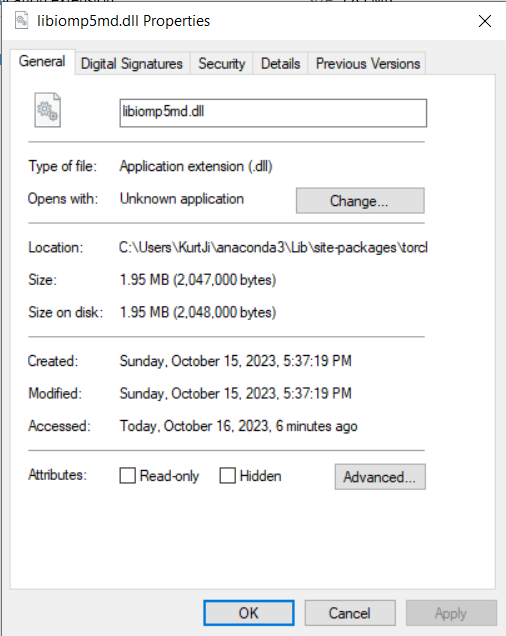
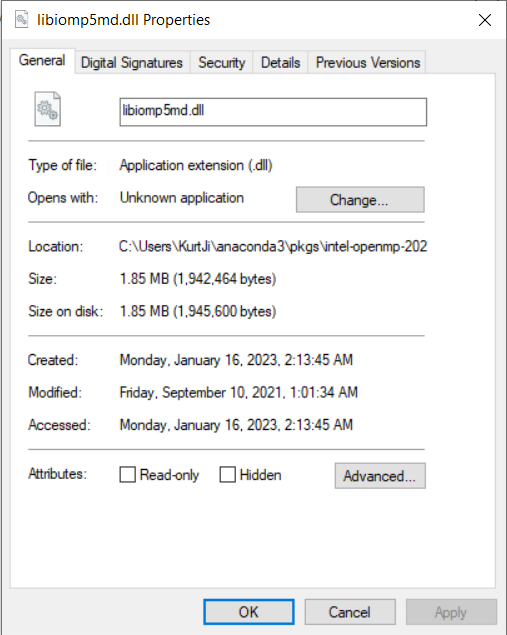
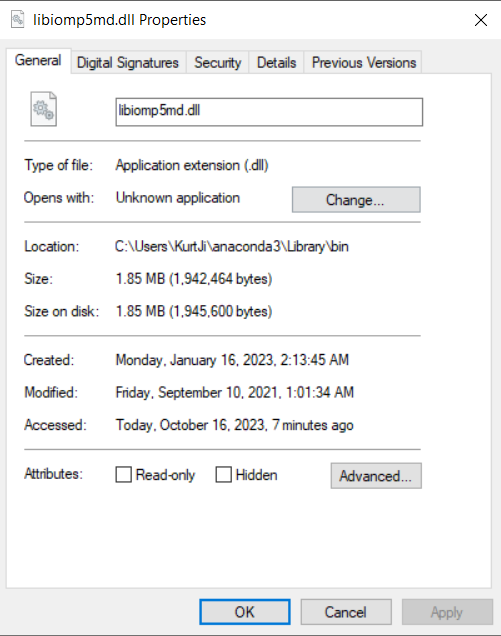 -->
For io errors, read this: https://stackoverflow.com/questions/20554074/sklearn-omp-error-15-initializing-libiomp5md-dll-but-found-mk2iomp5md-dll-a

**Note**: for this data loader I am reading files as csvs that contain image path and annotations.

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

import ast
import re

import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# root path
root_path = 'C:/Users/KurtJi/OneDrive - University of Illinois - Urbana/Desktop/Personal Projects/data/inaturalist/'

**Define Hyper Parameters**

In [3]:
# Hyper parameters
num_epochs = 8
num_classes = 4
batch_size = 256
learning_rate = 0.002

**Check data structure**

In [4]:
mbra_df = pd.read_csv('mbra_dataset.csv')
mbra_df = mbra_df.sample(n=5000).reset_index(drop=True)

n = 3833
img_name = mbra_df.iloc[n, 0]
class_name = mbra_df.loc[n, 'class']
common_name = mbra_df.loc[n, 'common_name']

print('Image name: {}'.format(img_name))
print(class_name, common_name)

Image name: train_mini/03249_Animalia_Chordata_Aves_Anseriformes_Anatidae_Histrionicus_histrionicus/7e0f6a4f-5aa0-4a28-8e49-cf716d8f05bf.jpg
Aves Harlequin Duck


**Plot a sample image**

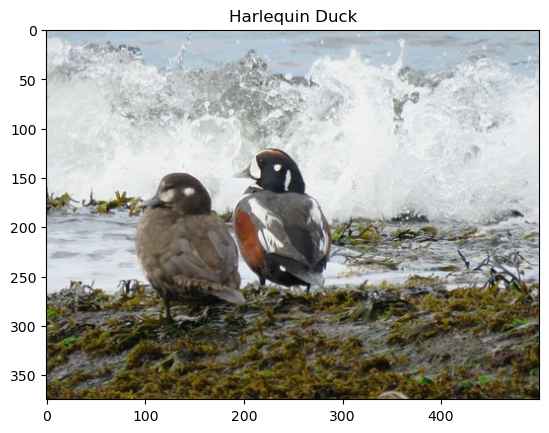

In [6]:
def show_animals(image, label):
    """Show image with label"""
    plt.title(label)
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated
    # Add a title to the plot


plt.figure()
show_animals(io.imread(os.path.join(root_path, img_name)),
               common_name)
plt.show()

### **Dataset Class**

In [7]:
class MbraDataset(Dataset):
    """Face label dataset."""

    def __init__(self, df, root_dir, csv_file=None, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if csv_file:
            self.df = pd.read_csv(csv_file)
        else:
            self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    # def __getitem__(self, idx):
    #     if torch.is_tensor(idx):
    #         idx = idx.tolist()

    #     img_path = os.path.join(self.root_dir,
    #                             self.df.iloc[idx, 0])
    #     # print(img_path)
    #     image = io.imread(img_path)
    #     label = self.df.iloc[idx, 1]
    #     sample = {'image': image, 'label': label}

    #     if self.transform:
    #         sample = self.transform(sample)

    #     return sample

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = io.imread(img_path) # Load the image using skimage.io
        label = self.df.iloc[idx, 1]

        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

**Create dataset with class names**

In [12]:
# get the dataframe with only the image and the class level name
mbra_df_class = mbra_df[['image_path', 'class']].copy()

**Encode string data to int**

In [13]:
from sklearn import preprocessing

class_labels = mbra_df_class['class'].tolist()

le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(class_labels)

# Create a label map (class_name -> encoded_integer)
class_map = dict(zip(encoded_labels, class_labels))


mbra_df_class['class'] = encoded_labels

mbra_df_class.head()


,image_path,class
0,train_mini/03064_Animalia_Chordata_Amphibia_Ca...,0
1,train_mini/03197_Animalia_Chordata_Aves_Anseri...,1
2,train_mini/04368_Animalia_Chordata_Aves_Peleca...,1
3,train_mini/03707_Animalia_Chordata_Aves_Passer...,1
4,train_mini/04140_Animalia_Chordata_Aves_Passer...,1


In [14]:
class_map

{0: 'Amphibia', 1: 'Aves', 2: 'Mammalia', 3: 'Reptilia'}

0 (500, 375, 3) Amphibia


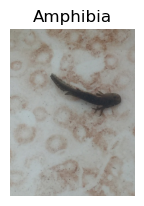

1 (333, 500, 3) Aves


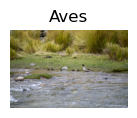

2 (333, 500, 3) Aves


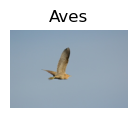

3 (344, 480, 3) Aves


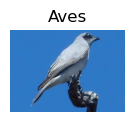

In [15]:
# construct a custom dataset
mbra_data_class = MbraDataset(mbra_df_class,
                                    root_dir=root_path)

fig = plt.figure()

for i, sample in enumerate(mbra_data_class):
    print(i, sample['image'].shape, class_map[sample['label']])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_animals(sample['image'], class_map[sample['label']])

    if i == 3:
        plt.show()
        break


### **Add Transformer**

In [19]:
from sklearn import preprocessing
import torch

In [21]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        new_h, new_w = self.output_size, self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for label because for images,
        # x and y axes are axis 1 and 0 respectively
        # label = label * [new_w / w, new_h / h]

        return {'image': img, 'label': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        # label = label - [left, top]

        return {'image': image, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        # return {'image': torch.from_numpy(image),
        #         'label': torch.as_tensor((label,))}
        return {'image': torch.from_numpy(image).float(),  # convert the image to a float Tensor
                'label': label}  # keep the label as an integer

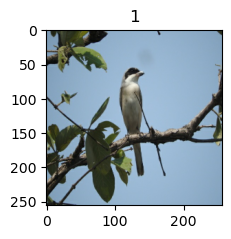

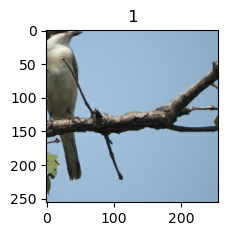

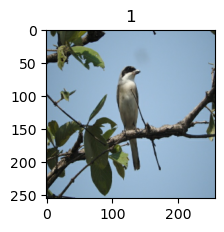

In [22]:
scale = Rescale(256)
crop = RandomCrop(256)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(256)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = mbra_data_class[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_animals(**transformed_sample)

plt.show()

### **Apply Dataloader**

In [23]:
mbra_df_class.head()

,image_path,class
0,train_mini/03064_Animalia_Chordata_Amphibia_Ca...,0
1,train_mini/03197_Animalia_Chordata_Aves_Anseri...,1
2,train_mini/04368_Animalia_Chordata_Aves_Peleca...,1
3,train_mini/03707_Animalia_Chordata_Aves_Passer...,1
4,train_mini/04140_Animalia_Chordata_Aves_Passer...,1


In [25]:
mbra_data_class = MbraDataset(df = mbra_df_class,
                                           root_dir=root_path,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensor()
                                           ]))

for i, sample in enumerate(mbra_data_class):
    print(i, sample['image'].size(), sample['label'])

    if i == 5:
        break

0 torch.Size([3, 256, 256]) 0
1 torch.Size([3, 256, 256]) 1
2 torch.Size([3, 256, 256]) 1
3 torch.Size([3, 256, 256]) 1
4 torch.Size([3, 256, 256]) 1
5 torch.Size([3, 256, 256]) 1


### **Train/Test Split**

In [28]:
train_size = int(0.8 * len(mbra_data_class))
test_size = len(mbra_data_class) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mbra_data_class, [train_size, test_size])

In [29]:
for i, sample in enumerate(train_dataset):
    print(i, sample['image'].size(), sample['label'])

    if i == 5:
        break

0 torch.Size([3, 256, 256]) 1
1 torch.Size([3, 256, 256]) 1
2 torch.Size([3, 256, 256]) 1
3 torch.Size([3, 256, 256]) 1
4 torch.Size([3, 256, 256]) 1
5 torch.Size([3, 256, 256]) 1


In [30]:
train_loader = DataLoader(train_dataset, batch_size=256,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=256//2,
                        shuffle=False, num_workers=0)


In [31]:
len(train_loader)

16

In [21]:
# # Helper function to show a batch
# def show_animal_batch(sample_batched):
#     """Show image with landmarks for a batch of samples."""
#     images_batch, labels_batch = \
#             sample_batched['image'], sample_batched['label']
#     batch_size = len(images_batch)
#     im_size = images_batch.size(2)
#     # grid_border_size = 2

#     grid = utils.make_grid(images_batch)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))

#     for i in range(batch_size):
#         #print(class_map[int(labels_batch[i])])

#         plt.title('Batch from dataloader')

# # if you are using Windows, uncomment the next line and indent the for loop.
# # you might need to go back and change ``num_workers`` to 0.

# # if __name__ == '__main__':
# for i_batch, sample_batched in enumerate(dataloader):
#     #print(i_batch, sample_batched['image'].size(),
#     #      sample_batched['label'].size())

#     # observe 4th batch and stop.
#     if i_batch == 3:
#         plt.figure()
#         show_animal_batch(sample_batched)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

# **Building Simple CNN**

#### **Check device**

In [32]:
!conda info --envs

# conda environments:
#
                         C:\Users\KurtJi\AppData\Local\R-MINI~1
                         C:\Users\KurtJi\AppData\Local\R-MINI~1\envs\r-reticulate
                         C:\Users\KurtJi\AppData\Local\r-miniconda
                         C:\Users\KurtJi\anaconda3
                         C:\Users\KurtJi\miniconda3
base                  *  c:\Users\KurtJi\anaconda3



**CUDA+PyTorch Tutorial** https://blog.csdn.net/qq_45956730/article/details/126600028

In [33]:
import torch
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
torch.cuda.is_available()

True

In [35]:
device = torch.cuda.current_device()
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Laptop GPU'

### **Model Structure**

In [36]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [27]:
# # Creating a CNN class
# # image size is (3,256, 256)
# class SimpleCNN(nn.Module):
# 	#  Determine what layers and their order in CNN object 
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
#         self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
#         self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
#         self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
#         self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
#         self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
#         self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
#         self.fc1 = nn.Linear(1600, 128)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(128, num_classes)
    
#     # Progresses data across layers    
#     def forward(self, x):
#         out = self.conv_layer1(x)
#         out = self.conv_layer2(out)
#         out = self.max_pool1(out)
        
#         out = self.conv_layer3(out)
#         out = self.conv_layer4(out)
#         out = self.max_pool2(out)
                
#         out = out.reshape(out.size(0), -1)
        
#         out = self.fc1(out)
#         out = self.relu1(out)
#         out = self.fc2(out)
#         return out

In [37]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 4) # !!!
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [29]:
# # Train the model
# total_step = len(train_loader)
# print(total_step)
# for epoch in range(num_epochs):
#     for i, data in enumerate(train_loader, 1):
#         images,labels=data
#         print(type(images), type(labels))
#         images = images.to(device)
#         print(images)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [30]:
# import torch
# torch.cuda.empty_cache()

In [38]:
# import gc
# del variables
# gc.collect()
model = SimpleCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

model.cuda()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Line

In [39]:
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor

In [43]:
num_epochs = 8

In [45]:
# Train the model
total_step = len(train_loader)
print(total_step)
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):  # replace 'data_loader' with your actual DataLoader
        images = batch['image']
        labels = batch['label']
        # print(type(images), type(labels))
        # images = images.to(device)
        # # print(images)
        # labels = labels.to(device)
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda() 
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

16
Epoch [1/8], Step [1/16], Loss: 0.8027
Epoch [1/8], Step [2/16], Loss: 0.7609
Epoch [1/8], Step [3/16], Loss: 0.8528
Epoch [1/8], Step [4/16], Loss: 0.8910
Epoch [1/8], Step [5/16], Loss: 0.8417
Epoch [1/8], Step [6/16], Loss: 0.7708
Epoch [1/8], Step [7/16], Loss: 0.7021
Epoch [1/8], Step [8/16], Loss: 0.8554
Epoch [1/8], Step [9/16], Loss: 0.8163
Epoch [1/8], Step [10/16], Loss: 0.7681
Epoch [1/8], Step [11/16], Loss: 0.8588
Epoch [1/8], Step [12/16], Loss: 0.8811
Epoch [1/8], Step [13/16], Loss: 0.8190
Epoch [1/8], Step [14/16], Loss: 0.8242
Epoch [1/8], Step [15/16], Loss: 0.7144
Epoch [1/8], Step [16/16], Loss: 0.7478
Epoch [2/8], Step [1/16], Loss: 0.7919
Epoch [2/8], Step [2/16], Loss: 0.8560
Epoch [2/8], Step [3/16], Loss: 0.7906
Epoch [2/8], Step [4/16], Loss: 0.7170
Epoch [2/8], Step [5/16], Loss: 0.8473
Epoch [2/8], Step [6/16], Loss: 0.7724
Epoch [2/8], Step [7/16], Loss: 0.8077
Epoch [2/8], Step [8/16], Loss: 0.6936
Epoch [2/8], Step [9/16], Loss: 0.8929
Epoch [2/8], St

In [49]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(test_loader):  # replace 'data_loader' with your actual DataLoader
        images = batch['image']
        labels = batch['label']
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 1000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 1000 test images: 67.6 %


In [47]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 165718 KiB |  16219 MiB |   7402 GiB |   7402 GiB |
|       from large pool | 164160 KiB |  16218 MiB |   7401 GiB |   7401 GiB |
|       from small pool |   1558 KiB |      2 MiB |      0 GiB |      0 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 165718 KiB |  16219 MiB |   7402 GiB |   7402 GiB |
|       from large pool | 164160 KiB |  16218 MiB |   7401 GiB |